## GCN Discriminative Model on PETase

## CbAS in PyTorch

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, ShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
from scipy import stats
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
plt.rcParams['figure.dpi'] = 300
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Setting up data

In [ ]:
AA = ['a', 'r', 'n', 'd', 'c', 'q', 'e', 'g', 'h', 'i', 'l', 'k', 'm', 'f', 'p', 's', 't', 'w', 'y', 'v']
AA_IDX = {AA[i]:i for i in range(len(AA))}
IDX_AA = {AA_IDX[k]:k.upper() for k in AA_IDX.keys()}

def one_hot_encode_aa(aa_str, pad=None):
    try:
        M = len(aa_str)
    except TypeError:
        print(aa_str)
    aa_str = aa_str.lower()
    aa_arr = np.zeros((M, 20), dtype=int)
    for i in range(M):
        aa_arr[i, AA_IDX[aa_str[i]]] = 1
    return aa_arr

def get_X(seqs):
    print(len(seqs))
    M = len(seqs[0])
    N = len(seqs)
    X = np.zeros((N, 298, 20))
    for i in range(N):
        # X[j] = convert_aas_to_idx_array([seqs[i]]).reshape(-1,1)
        X[i] = one_hot_encode_aa(seqs[i])
    return X

def get_seq(s):
    seq = ""
    for i in s:
        seq += IDX_AA[i]
    return seq

def get_samples(Xt_p):
    Xt_sampled = np.zeros_like(Xt_p)
    b, l, d = Xt_p.shape
    # probs = np.zeros((b, l))
    for i in range(b):
        for j in range(l):
            p = Xt_p[i, j]
            # k = np.random.choice(range(len(p)), p=p)
            k = np.argmax(p)
            # probs[i, j] = p[k]
            Xt_sampled[i, j, k] = 1.
    return Xt_sampled #, probs

def convert_idx_array_to_aas(X_aa):
    N = len(X_aa)
    M = len(X_aa[0])
    X_aa_str = [["A"] * M] * N
    for i in range(N):
        for j in range(M):
            X_aa_str[i][j] = AA[X_aa[i, j]]
        X_aa_str[i] = "".join(X_aa_str[i])
    return X_aa_str

In [ ]:
seed_val = 777
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
batch_size = 10

class SequenceData(Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        # print(X.shape)
        # self.X = self.X.reshape(-1, 768)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Oracles

In [ ]:
def train_oracle(X, y, save_name):
    """Raw values of y are fitted, they should be normalized prior to this
        function if you prefer.
    """
    petase_dataset = SequenceData(X, y)
    train, test = train_test_split(list(range(X.shape[0])), test_size=.2)

    petase_train = DataLoader(petase_dataset, batch_size=batch_size,
                          sampler=SubsetRandomSampler(train))
    petase_test = DataLoader(petase_dataset, batch_size=batch_size,
                          sampler=SubsetRandomSampler(test))
    
    for i in range(1):
        random.seed(i)
        model = torch.nn.Sequential(
            torch.nn.Linear(298*20, 20),
            torch.nn.ELU(),
            torch.nn.Linear(20, 1),
            torch.nn.Tanh(),
        )
        model.to(device)
        model.double()
        loss_fn = nn.MSELoss(reduction='sum')

        learning_rate = 1e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-3, cycle_momentum=False)
        train_loss, test_loss = [], []
        best_test_loss = 1e3
        img_idx = 0
        for epoch in range(200):
            total_train_loss, total_test_loss = 0, 0
            # for x, y in ps_train:
            for x, y in petase_train:        
                model.train()
                optimizer.zero_grad()

                y_hat = model(x.reshape(-1,298*20).to(device))
                loss = loss_fn(y.reshape(-1,1).to(device), y_hat)
                total_train_loss += loss.item()

                loss.backward()
                optimizer.step()
                scheduler.step()
            train_loss.append(total_train_loss / len(petase_train))

            for x, y in petase_test:
                model.eval()
                y_hat = model(x.reshape(-1,298*20).to(device))

                loss = loss_fn(y.reshape(-1,1).to(device), y_hat)
                total_test_loss += loss.item()
            test_loss.append(total_test_loss / len(petase_test))

            if (epoch+1) % 10 == 0:
                print("Training loss: {}".format(train_loss[-1]))
                print("Validation loss: {}".format(test_loss[-1]))

            if test_loss[-1] < best_test_loss:
                plt.clf()
                torch.save(model.state_dict(), "{}_model.pt".format(save_name))
                # model.eval()
                # train_preds = []
                # train_reals = []
                # test_preds, test_reals = [], []
                # for x, y in petase_train:        
                #     preds = model(x.reshape(-1,298*20).to(device))
                #     preds = preds.detach().cpu().numpy()
                #     train_preds.extend(list(preds))
                #     reals = y
                #     train_reals.extend(list(reals))

                # for x, y in petase_test:
                #     preds = model(x.reshape(-1,298*20).to(device))
                #     preds = preds.detach().cpu().numpy()
                #     test_preds.extend(list(preds))
                #     reals = y
                #     test_reals.extend(list(reals))
                # train_reals = [a.item() for a in train_reals]
                # train_preds = [a.item() for a in train_preds]
                # plt.scatter(train_reals, train_preds)
                # test_reals = [a.item() for a in test_reals]
                # test_preds = [a.item() for a in test_preds]
                # plt.scatter(test_reals, test_preds)
                # plt.xlabel("Actual log activity")
                # plt.ylabel("Predicted log activity")
                # # plt.savefig("scatter.png", dpi=300)
                # plt.show()
                # # plt.savefig("images/{}.png".format(img_idx), dpi=100)
                # # img_idx += 1
                # print("Training, Model {}: ".format(i), stats.spearmanr(train_reals, train_preds)[0])
                # print("Testing, Model {}: ".format(i), stats.spearmanr(test_reals, test_preds)[0])
        plt.clf()
        plt.plot(train_loss)
        plt.plot(test_loss)
        print("Minimum test loss:", min(test_loss))
        plt.xlabel("Epoch")
        plt.ylabel("Mean Squared Error")
        plt.savefig("loss_plot.png", dpi=300)
        plt.show()

### VAE

Code adapted from https://sites.google.com/view/berkeley-cs294-158-sp20/home homework 3

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep_seq-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
--2020-09-18 19:34:57--  https://docs.google.com/uc?export=download&confirm=rPtw&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 172.217.204.139, 172.217.204.102, 172.217.204.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/o67ru3a3bhsp9anbe331qib2ihm54j6o/6j1ue1vnabjpm24gvi34vpnhb8k79hn4/1600457625000/06419056966375271799/14637660846069541966Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-09-18 19:34:57--  https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/o67ru3a3bhsp9anbe331qib

In [ ]:
from deepul.hw3_helper import *

In [ ]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim


def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x, train_weights in train_loader:
        x = x.to(device)
        out = model.loss(x, train_weights)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x, test_weights in data_loader:
            x = x.to(device)
            out = model.loss(x, test_weights)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, t, train_args, quiet=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    best_loss = 1e7
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip)
        test_loss = eval_loss(model, test_loader, quiet)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
        # print("VAE test losses: ")
        # print(test_losses['loss'][-1])
        # if test_losses['loss'][-1] < best_loss:
        #     best_loss = test_losses['loss'][-1]
        #     torch.save(model.state_dict(), "vae_{}.pt".format(t))
    return train_losses, test_losses


class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()

        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        model = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.net(x).view(b, *self.output_shape)


class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hidden_sizes=[],
                 dec_hidden_sizes=[]):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLP(input_dim, 2 * latent_dim, enc_hidden_sizes)
        self.decoder = MLP(latent_dim, 2 * input_dim, dec_hidden_sizes)

    def loss(self, x, w):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        # Compute reconstruction loss - Note that it may be easier for you
        # to use torch.distributions.normal to compute the log_prob
        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
        recon_loss = recon_loss.sum(1)
        recon_loss = torch.sum(recon_loss * w) / len(recon_loss)

        # Compute KL
        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.sum(1)
        kl_loss = torch.sum(kl_loss * w) / len(kl_loss)

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).to(device)
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()

In [ ]:
class SequenceData(Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        # print(X.shape)
        # self.X = self.X.reshape(-1, 768)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
def train_vae(data, weights, t):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """ 

    # model = FullyConnectedVAE(126, 126, [64, 32], [32, 64]).to(device)
    # model = FullyConnectedVAE(126*4, 126*4, [128, 64], [64, 128]).to(device)
    model = FullyConnectedVAE(298*20, 298*20, [20, 20], [20, 20]).to(device)

    # train_loader = data.DataLoader(train_data, batch_size=10, shuffle=True)   # need to include weights here as pairs (x, weight_x)
    # test_loader = data.DataLoader(test_data, batch_size=10)
    data = data.reshape(-1, 298*20).astype(np.float32)
    petase_dataset = SequenceData(data, weights)

    train, test = train_test_split(list(range(len(data))), test_size=.1)

    train_loader = DataLoader(petase_dataset, batch_size=10,
                          sampler=SubsetRandomSampler(train), shuffle=False)
    test_loader = DataLoader(petase_dataset, batch_size=10,
                          sampler=SubsetRandomSampler(test), shuffle=False)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, t,
                                             dict(epochs=100, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    torch.save(model.state_dict(), "vae_{}.pt".format(t))

    # train_loader = data.DataLoader(finetune_data, batch_size=10, shuffle=True)
    # train_losses, test_losses = train_epochs(model, train_loader, test_loader,
    #                                          dict(epochs=20, lr=1e-3), quiet=True)
    # train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    # test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)


    # samples_noise = model.sample(1000, noise=True)
    # samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses #, samples_noise, samples_nonoise

In [ ]:
def plot_vae_training_plot(train_losses, test_losses, title, fname):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train[1:], elbo_train[1:], label='-elbo_train')
    plt.plot(x_train[1:], recon_train[1:], label='recon_loss_train')
    plt.plot(x_train[1:], kl_train[1:], label='kl_loss_train')
    plt.plot(x_test[1:], elbo_test[1:], label='-elbo_test')
    plt.plot(x_test[1:], recon_test[1:], label='recon_loss_test')
    plt.plot(x_test[1:], kl_test[1:], label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    savefig(fname)

def run_train_vae(fn, t, data, weights=None):
    # train_data, test_data = q1_sample_data(part, dset_id)
    # train_losses, test_losses, samples_noise, samples_nonoise = fn(data, weights,
    #                                                                part, dset_id, finetune_data)
    
    # print(f'Finl -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
    #       f'KL Loss: {test_losses[-1, 2]:.4f}')

    # plot_vae_training_plot(train_losses, test_losses, f'Q1({part}) Dataset {dset_id} Train Plot',
    #                        f'results/q1_{part}_dset{dset_id}_train_plot.png')
    # print(samples_noise.shape)
    # np.save("ps_noise.npy", samples_noise)
    # np.save("ps_nonoise.npy", samples_nonoise)
    pass


Sample from VAE

### Optimization

In [ ]:
def mysoftmax(Xt_p):
    eXt_p = np.exp(Xt_p)
    return eXt_p / np.sum(eXt_p, axis=2, keepdims=True)

In [ ]:
def get_balaji_predictions(oracles, Xt):
    M = len(oracles)
    N = Xt.shape[0]
    all_preds = np.zeros((M, N))
    for m in range(M):    # batch this
        y_pred = []
        for i in range(0, len(Xt), 10):
            Xt_curr = Xt[i:i+10]
            pred_curr = oracles[m](Xt_curr).detach().numpy().flatten()
            y_pred.extend(list(pred_curr))
        y_pred = np.array(y_pred)
        all_preds[m, :] = y_pred.reshape(1,N)
    mean = np.mean(all_preds, axis=0).flatten()
    variance = np.var(all_preds, axis=0).flatten()
    return mean, variance
    

In [ ]:
def weighted_ml_opt(X_train, cat_oracles, therm_oracles, vae_0,
        latent_dim=20, iters=20, samples=1000, homoscedastic=False, homo_y_var=0.1,
        quantile=0.95, verbose=False, alpha=1, train_gt_evals=None,
        cutoff=1e-6, it_epochs=10, enc1_units=50):
    """
    X_train has size (batch, seqlen, 20)
    """
    vae = FullyConnectedVAE(298*20, 298*20, [20, 20], [20, 20])#.to(device)
    traj = np.zeros((iters, 1))
    oracle_samples = np.zeros((iters, samples))
    oracle_max_seq = None
    oracle_max = -np.inf
    y_star = -np.inf
    for t in range(iters):
        if t > 0:
            Xt_p = vae.sample(1000, noise=False).reshape(1000, 298, 20)
            Xt_p = mysoftmax(Xt_p)
            Xt = get_samples(Xt_p)
            Xt_ll = np.sum(np.log(Xt_p) * Xt, axis=(1, 2))
        else:
            Xt = X_train
        Xt = Xt.astype(np.float32)
        Xt_flat = torch.from_numpy(Xt.reshape(-1,298*20)).to(device)
        
        # yt_cat = np.array(yt_cat)
        # yt_therm = np.array(yt_therm)

        yt_cat, yt_cat_var = get_balaji_predictions(cat_oracles, Xt_flat)
        yt_therm, yt_therm_var = get_balaji_predictions(therm_oracles, Xt_flat)
        yt = yt_cat + yt_therm
        yt = np.array(yt).flatten()
        yt_var = yt_cat_var + yt_therm_var
        yt_var = np.array(yt_var).flatten()

        if homoscedastic:
            yt_var = np.ones_like(yt) * homo_y_var
        Xt_aa = np.argmax(Xt, axis=-1)
        print("Xt_aa shape: ", Xt_aa.shape)
        if t > 0:
            log_pxt = np.sum(np.log(Xt_p) * Xt, axis=(1, 2))
            X0_p = vae_0.sample(1000, noise=False).reshape(1000, 298, 20)
            X0_p = mysoftmax(X0_p)
            log_px0 = np.sum(np.log(X0_p) * Xt, axis=(1, 2))
            ratio = log_px0-log_pxt
            ratio = 2 * (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
            w1 = np.exp(ratio)
            y_star_1 = np.percentile(yt, quantile*100)
            if y_star_1 > y_star:
                y_star = y_star_1
            w2= scipy.stats.norm.sf(y_star, loc=yt, scale=np.sqrt(yt_var))
            weights = w1*w2 
        else:
            weights = np.ones(yt.shape[0])

        yt_max_idx = np.argmax(yt)
        yt_max = yt[yt_max_idx]
        if t > 0:
            ydx = np.argsort(yt)[-5:]
            seq = []
            seqs = Xt_aa[ydx]
            ll = Xt_ll[ydx]
            for s in seqs:
                seq.append(get_seq(s))
            print("\n===== Iteration {} =====".format(t))
            print("Sequences: ", seq)
            print("Predicted catalytic: ", yt_cat[ydx])
            print("Catalytic uncertainty: ", yt_cat_var[ydx])
            print("Predicted thermostability: ", yt_therm[ydx])
            print("Stability uncertainty: ", yt_therm_var[ydx])
            print("Likelihoods: ", ll)

        if yt_max > oracle_max:
            oracle_max = yt_max
            # print("Max shapes: ")
            # print(Xt_aa.shape)
            # print(yt.shape)
            # oracle_max_seq = convert_idx_array_to_aas(Xt_aa[yt_max_idx-1:yt_max_idx])[0]  # CHECK
            # print("Max seq 1: ", oracle_max_seq)
            # print(yt[yt_max_idx-1])
            oracle_max_seq = convert_idx_array_to_aas(Xt_aa[yt_max_idx:yt_max_idx+1])[0]
            print("Max seq 2: ", oracle_max_seq.upper())
            print(yt[yt_max_idx])

        if t > 0:
            oracle_samples[t, :] = yt
        else:
            rand_idx = np.random.randint(0, len(yt), samples)
            oracle_samples[t, :] = yt[rand_idx]

        traj[t, 0] = np.max(yt)
        print("Current max: ", traj[t,0])

        if t > 0:
            cutoff = np.percentile(weights, 20)
            cutoff_idx = np.where(weights < cutoff)
            Xt = np.delete(Xt, cutoff_idx, axis=0)
            yt = np.delete(yt, cutoff_idx, axis=0)
            weights = np.delete(weights, cutoff_idx, axis=0)
            print("Weights")
            print(np.min(weights))
            print(np.max(weights))
            Xt = Xt.reshape(-1, 298*20)
            print("Xt shape", Xt.shape)
            train_vae(Xt, weights, t)
            vae.load_state_dict(torch.load("vae_{}.pt".format(t), map_location=device))
        else:
            sd = torch.load("vae_0.pt", map_location=device)
            vae.load_state_dict(sd)   # or can be more flexible and allow for training
    return traj


In [ ]:
# !tar -xzf stability_models.tar.gz
!tar -xzf catalytic_models.tar.gz

In [ ]:
df = pd.read_csv("petase_activity.csv")
X_activity = get_X(list(df['sequence'])[:212])
X_activity = X_activity.reshape(-1, 298, 20)
y_activity = np.array(list(df['relative_activity']))[:212]
y_activity = np.log(y_activity + 0.001)
y_activity = ((y_activity - np.min(y_activity)) / (np.max(y_activity) - np.min(y_activity))) - 0.5  # don't let it saturate the sigmoid
df = pd.read_csv("petase_stability.csv")
X_stability = get_X(list(df['sequence'])[:159])
X_stability = X_stability.reshape(-1, 298, 20)
y_stability = np.array(list(df['stability']))[:159]
y_stability = np.log(y_stability + 0.001)
y_stability = ((y_stability - np.min(y_stability)) / (np.max(y_stability) - np.min(y_stability))) - 0.5

# train oracles
# train_oracle(X_activity, y_activity, "catalytic")
# train_oracle(X_stability, y_stability, "stability")

# train VAE
# weights = torch.ones(X_activity.shape[0]).to(device)
# train_vae(X_activity, weights, 0)

# # run CbAS
cat_oracles, therm_oracles = [], []
for i in range(20):
    cat_model = torch.nn.Sequential(
        torch.nn.Linear(298*20, 20),
        torch.nn.ELU(),
        torch.nn.Linear(20, 1),
        torch.nn.Tanh(),
    )
    therm_model = torch.nn.Sequential(
        torch.nn.Linear(298*20, 20),
        torch.nn.ELU(),
        torch.nn.Linear(20, 1),
        torch.nn.Tanh(),
    )
    cat_model.load_state_dict(torch.load("catalytic_model_{}.pt".format(i), map_location=device))
    therm_model.load_state_dict(torch.load("stability_model_{}.pt".format(i), map_location=device))
    cat_oracles.append(cat_model)
    therm_oracles.append(therm_model)

vae_0 = FullyConnectedVAE(298*20, 298*20, [20, 20], [20, 20]).to(device)
vae_0.load_state_dict(torch.load("vae_0.pt", map_location=device))
traj = weighted_ml_opt(X_activity, cat_oracles, therm_oracles, vae_0)
plt.plot(traj[:,0])
plt.savefig("traj.png", dpi=250)
plt.show()

212
159
Xt_aa shape:  (212, 298)
Max seq 2:  MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPSGYGAGTVYYPTNAGGEVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTFDYPSSRSSQQMAALRQVASLNGDSSSPIYGKVDTARMGVMGHSMGGGASLRSAANNPSLKAAIPQAPWDSQTNFSSVTVPTLIFACENDSIAPVNSHALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTAVSDFRTANCSLEHHHHHH
1.0543207392096519
Current max:  1.0543207392096519
Xt_aa shape:  (1000, 298)

===== Iteration 1 =====
Sequences:  ['MNFPRWSRQRQAAKLGGDMAVSQAATAQLNPYKRLRQKTLDILEASITPGMVRSFTVRRDSGYEAGTLYLPTNTGGIVGAIAIVPGYCAGQSSIAWWGPRLASHGKVVIEIDTNSNEGQPESAHSQQMSNLKIVASLNGILSSLIYGHVQVARMYYMGHSMHGKGSLRSAANRQSLKQQNPQAPGDDQTNFISGCVPTLARACHNDSIAAVNSHALPQYDSMSHNAKQFLEINGGSHNCLNSGNSNNALSEKKVVAWMKGFMDNDHYNSTFACWNPNKINVSDFRTANCSLGHHVFHH', 'MNIFLWSLQMQPAKLGGGMMWLARAKDQLNPHKRAIQKTLDIVPCLATPKHVRTNTDRRDSGNEAETRPVPTNTTGFVGEITIVPTYCAGQSSGIWWGPRLADHGIVVIHIDTNSTQMQHESAHSQQVSNLKPVAQLNGILSSDIEGHVQGFRMRYMGSSFSGKGIKRSAPNRQSRKQQFPQAPGRRQTWFISGSVPRSARTCENDSMADVNSHALPNIIGMSNQATNFLEINAGSH

In [ ]:
def train_oracle(petase_train, petase_test, save_name):
    """Evaluate uncertainty in oracle's predictions
    """
    all_train_loss, all_test_loss = [], []
    for i in range(20):
        random.seed(i)
        model = torch.nn.Sequential(
            torch.nn.Linear(298*20, 20),
            torch.nn.ELU(),
            torch.nn.Linear(20, 1),
            torch.nn.Tanh(),
        )
        model.to(device)
        model.double()
        loss_fn = nn.MSELoss(reduction='sum')

        learning_rate = 1e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-3, cycle_momentum=False)
        train_loss, test_loss = [], []
        best_test_loss = 1e3
        img_idx = 0
        for epoch in range(200):
            total_train_loss, total_test_loss = 0, 0
            # for x, y in ps_train:
            for x, y in petase_train:        
                model.train()
                optimizer.zero_grad()

                y_hat = model(x.reshape(-1,298*20).to(device))
                loss = loss_fn(y.reshape(-1,1).to(device), y_hat)
                total_train_loss += loss.item()

                loss.backward()
                optimizer.step()
                # scheduler.step()
            train_loss.append(total_train_loss / len(petase_train))

            for x, y in petase_test:
                model.eval()
                y_hat = model(x.reshape(-1,298*20).to(device))

                loss = loss_fn(y.reshape(-1,1).to(device), y_hat)
                total_test_loss += loss.item()
            test_loss.append(total_test_loss / len(petase_test))

            if (epoch+1) % 100 == 0:
                print("Training loss: {}".format(train_loss[-1]))
                print("Validation loss: {}".format(test_loss[-1]))

            if test_loss[-1] < best_test_loss:
                torch.save(model.state_dict(), "{}_model_{}.pt".format(save_name, i))
        all_train_loss.append(train_loss)
        all_test_loss.append(test_loss)
    all_train_loss = np.array(all_train_loss)
    all_test_loss = np.array(all_test_loss)
    mu1 = np.mean(all_train_loss, axis=0)
    mu2 = np.mean(all_test_loss, axis=0)
    sigma1 = np.std(all_train_loss, axis=0)
    sigma2 = np.std(all_test_loss, axis=0)
    fig, ax = plt.subplots(1)
    t = np.arange(200)
    ax.plot(t, mu1, lw=2, label='Training loss', color='blue')
    ax.plot(t, mu2, lw=2, label='Test loss', color='orange')
    ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
    ax.fill_between(t, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
    plt.show()
        

212
Training loss: 0.14248255814343344
Validation loss: 0.3587324220417155
Training loss: 0.06673282358130031
Validation loss: 0.36836742560786495
Training loss: 0.18408361382739855
Validation loss: 0.36786306709721817
Training loss: 0.06702774616043847
Validation loss: 0.3807271521853267
Training loss: 0.15721553904583216
Validation loss: 0.37077940562711725
Training loss: 0.06688212580718667
Validation loss: 0.3804473462705202
Training loss: 0.16322322663392755
Validation loss: 0.36800408745370045
Training loss: 0.07708773575056585
Validation loss: 0.4129326376537895
Training loss: 0.1440940804113438
Validation loss: 0.36972663104219833
Training loss: 0.06040981468531688
Validation loss: 0.3854921640636316
Training loss: 0.169887517581611
Validation loss: 0.39532073049488115
Training loss: 0.06930014703957255
Validation loss: 0.375718590319967
Training loss: 0.13727222960577043
Validation loss: 0.3946794835320605
Training loss: 0.06531053318941804
Validation loss: 0.3729043815703145


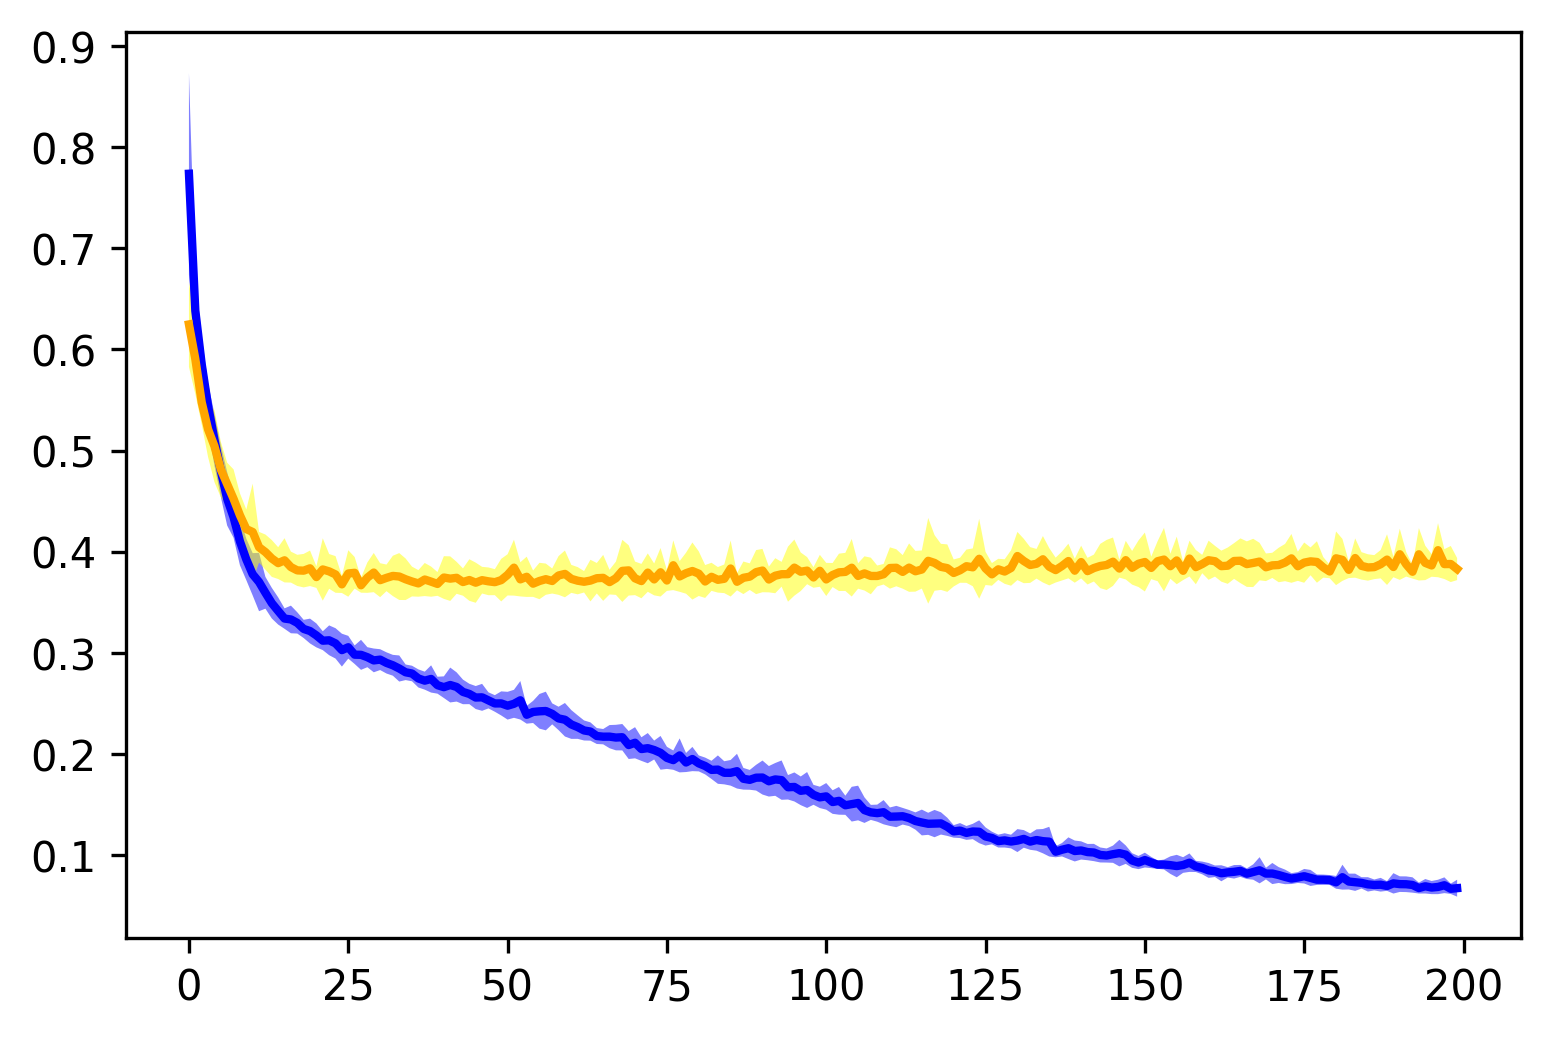

In [ ]:
   
df = pd.read_csv("petase_activity.csv")
X_activity = get_X(list(df['sequence'])[:212])
X_activity = X_activity.reshape(-1, 298, 20)
y_activity = np.array(list(df['relative_activity']))[:212]
y_activity = np.log(y_activity + 0.001)
y_activity = ((y_activity - np.min(y_activity)) / (np.max(y_activity) - np.min(y_activity))) - 0.5  # don't let it saturate the sigmoid
# df = pd.read_csv("petase_stability.csv")
# X_stability = get_X(list(df['sequence'])[:159])
# X_stability = X_stability.reshape(-1, 298, 20)
# y_stability = np.array(list(df['stability']))[:159]
# y_stability = np.log(y_stability + 0.001)
# y_stability = ((y_stability - np.min(y_stability)) / (np.max(y_stability) - np.min(y_stability))) - 0.5

petase_dataset = SequenceData(X_activity, y_activity)
random.seed(777)
train, test = train_test_split(list(range(X_activity.shape[0])), test_size=.2)

petase_train = DataLoader(petase_dataset, batch_size=batch_size,
                      sampler=SubsetRandomSampler(train))
petase_test = DataLoader(petase_dataset, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

# train oracles
train_oracle(petase_train, petase_test, "catalytic")

In [ ]:
!tar -czf catalytic_models.tar.gz catalytic_*.pt
!tar -czf stability_models.tar.gz stability_*.pt

In [ ]:
#@title

model = FullyConnectedVAE(298*20, 298*20, [128, 128], [128, 128]).to(device)
model.load_state_dict(torch.load("vae_0.pt"))
samples_noise = model.sample(1000, noise=False)
# samples_nonoise = model.sample(1000, noise=False)
print(samples_noise.shape)

int_to_aa = {AA_IDX[key]:key for key in AA_IDX}
seqs = []
for sample in samples_noise:
  sample = sample.reshape(298,20)
  aas = np.argmax(sample, axis=1)
  seq = ""
  for aa in aas:
    seq += int_to_aa[aa].upper()
  seqs.append(seq)
txt = ""
for i, s in enumerate(seqs):
  txt += ">{}\n".format(i)
  txt += s + '\n'
with open("vae0_samples.fasta", 'w') as g:
  g.write(txt)

In [ ]:
#@title
# train_data = X_petase[:180].reshape(-1, 298*20).astype(np.float32)
# test_data = X_petase[180:212].reshape(-1, 298*20).astype(np.float32)
# finetune_seqs = []
# print(train_data.shape)

train_seqs, test_seqs, finetune_seqs = [], [], []
with open("petase_ps.fasta", 'r') as f:
    line = f.readline()
    line = f.readline()
    seq = "MNFPRASRLMQAAVLGGLMAVSAAATAQ"
    while line:
        if line.startswith(">"):
            seq += "EHHHHHH"
            train_seqs.append(seq)
            seq = "MNFPRASRLMQAAVLGGLMAVSAAATAQ"
        else:
            seq += line.strip()
        line = f.readline()
test_seqs = train_seqs[900:]
train_seqs = train_seqs[:900]

train_data = get_X(train_seqs).reshape(-1, 298*20).astype(np.float32)
test_data = get_X(test_seqs).reshape(-1, 298*20).astype(np.float32)
print(train_data.shape)
finetune_data = X_petase[:212].reshape(-1, 298*20).astype(np.float32)